<a href="https://colab.research.google.com/github/monisham7121/final-project-crop-prediction/blob/main/agriculturecode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, median_absolute_error,
    mean_squared_log_error, mean_absolute_percentage_error, max_error,
    explained_variance_score, mean_poisson_deviance, mean_gamma_deviance,
    mean_tweedie_deviance, d2_absolute_error_score, d2_pinball_score, d2_tweedie_score
)
import joblib, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow.keras.activations, tensorflow.keras.optimizers, tensorflow.keras.losses
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install tensorflow

In [ ]:
# Load data
data = pd.read_csv('APY.csv')
print("\n=== Initial Data Exploration ===")
print("Columns:", data.columns)
print("\nDescriptive Statistics:")
print(data.describe())
print("\nData Info:")
print(data.info())
print("\nMissing Values:")
print(data.isna().sum())


=== Initial Data Exploration ===
Columns: Index(['State', 'District ', 'Crop', 'Crop_Year', 'Season', 'Area ',
       'Production', 'Yield'],
      dtype='object')

Descriptive Statistics:
           Crop_Year         Area     Production          Yield
count  345336.000000  3.453360e+05  3.403880e+05  345336.000000
mean     2008.887512  1.167147e+04  9.584726e+05      79.423135
std         6.564361  4.584079e+04  2.153068e+07     916.678396
min      1997.000000  4.000000e-03  0.000000e+00       0.000000
25%      2003.000000  7.400000e+01  8.700000e+01       0.550000
50%      2009.000000  5.320000e+02  7.170000e+02       1.000000
75%      2015.000000  4.112000e+03  7.182000e+03       2.470000
max      2020.000000  8.580100e+06  1.597800e+09   43958.330000

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345336 entries, 0 to 345335
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   State       345336 non-

In [ ]:
# Data Preprocessing
lab = LabelEncoder()

# Handle missing values
data['Production'] = data['Production'].fillna(data['Production'].mean())
for i in data.select_dtypes(include='object').columns:
    data[i] = lab.fit_transform(data[i])

data['Crop'] = data['Crop'].fillna(data['Crop'].mode())



In [ ]:
# Statistical Analysis
print("\n=== Statistical Analysis ===")
print("\nSkewness:")
print(data.skew())
print("\nKurtosis:")
print(data.kurtosis())




=== Statistical Analysis ===

Skewness:
State         -0.131397
District       0.065213
Crop          -0.186471
Crop_Year     -0.120474
Season         0.679536
Area          41.847782
Production    36.133382
Yield         14.764146
dtype: float64

Kurtosis:
State           -1.247184
District        -1.235616
Crop            -1.097078
Crop_Year       -1.189462
Season          -0.768968
Area          5418.760859
Production    1607.353735
Yield          260.546571
dtype: float64


In [ ]:
# Outlier Detection and Treatment
cols = []
for i in data.columns.values:
    scores = (data[i] - data[i].mean()) / data[i].std()
    outliers = np.abs(scores > 3).sum()
    if outliers > 0:
        cols.append(i)

for i in cols:
    q3 = data[i].quantile(0.75)
    q1 = data[i].quantile(0.25)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[i] >= lower_bound) & (data[i] <= upper_bound)]



In [ ]:
# Feature Selection
x = data.drop(['Yield', 'District '], axis=1)
y = data.Yield

select = SelectKBest(k=len(x)-1)
new = select.fit_transform(x, y)
score = select.scores_

print("\nFeature Scores:", score)

x = x.columns[select.get_support()]
x = data[x]
y = data['Yield']
print("\nSelected Features:", x.columns)




Feature Scores: [ 7.29457336 12.67767514 15.0153286  20.94782818 35.57813737 59.1772278 ]

Selected Features: Index(['State', 'Crop', 'Crop_Year', 'Season', 'Area ', 'Production'], dtype='object')


In [ ]:
# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.25,
    random_state=42,
)



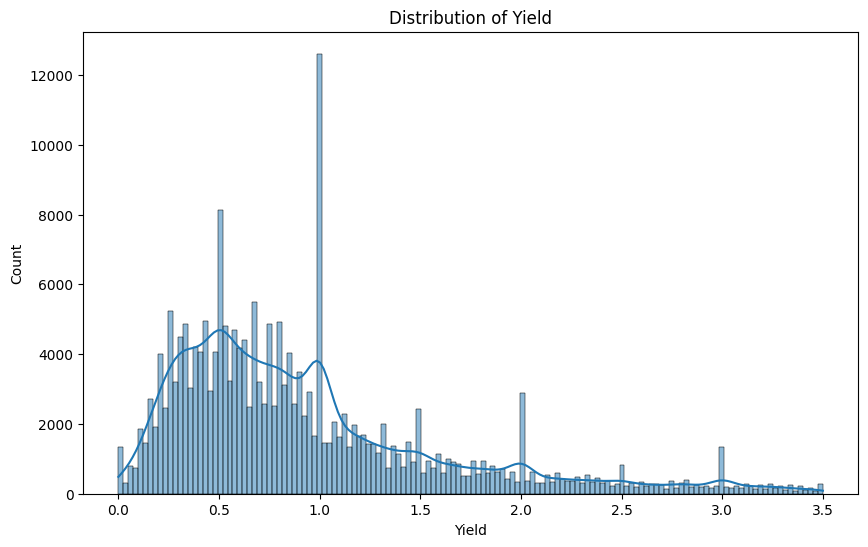

In [ ]:
# Create visualization directory
os.makedirs("./visualizations", exist_ok=True)

# =============================================
# Enhanced Statistical Visualizations (15+ plots)
# =============================================

# 1. Distribution of Target Variable (Yield)
plt.figure(figsize=(10, 6))
sns.histplot(data['Yield'], kde=True)
plt.title('Distribution of Yield')
plt.show()
plt.close()



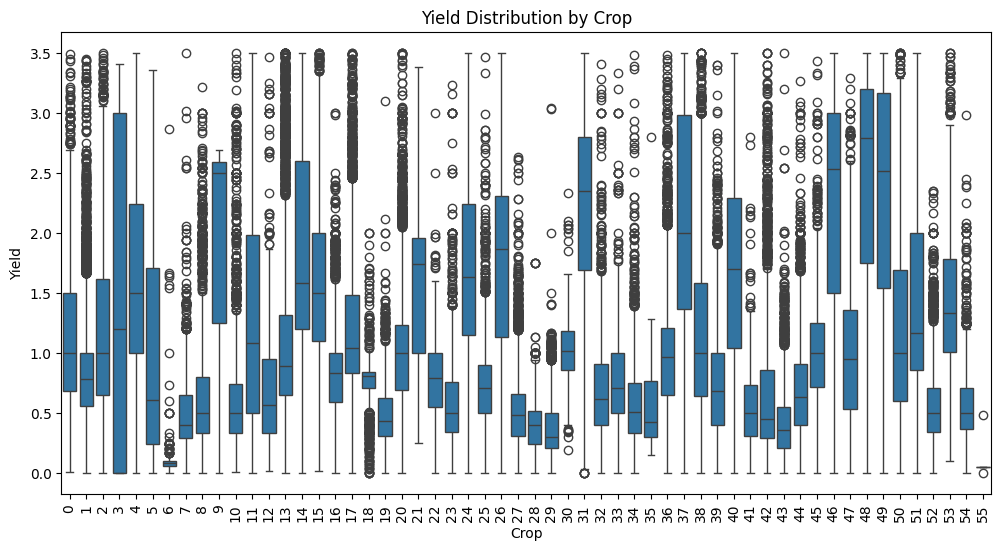

In [ ]:
# 2. Boxplot of Yield by Crop
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crop', y='Yield', data=data)
plt.title('Yield Distribution by Crop')
plt.xticks(rotation=90)
plt.show()
plt.close()



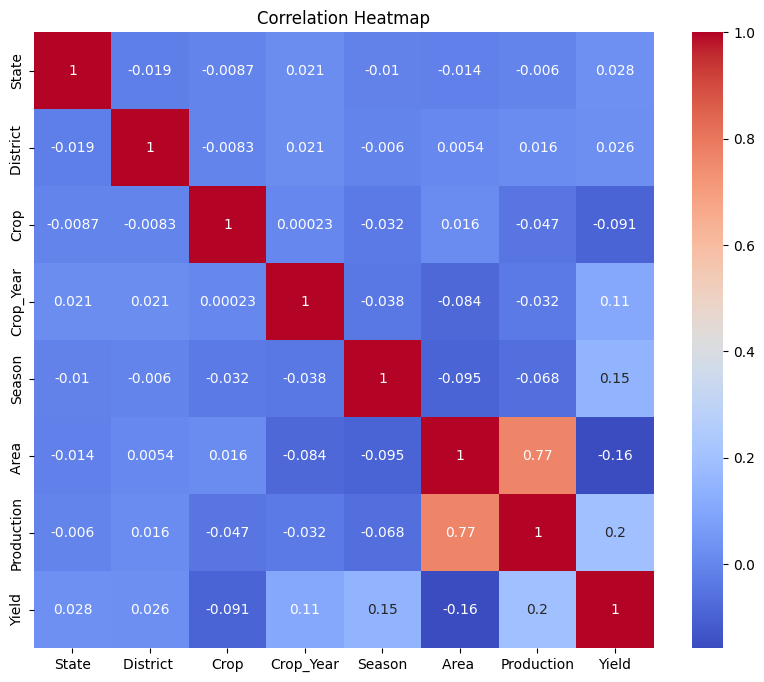

In [ ]:
# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
plt.close()

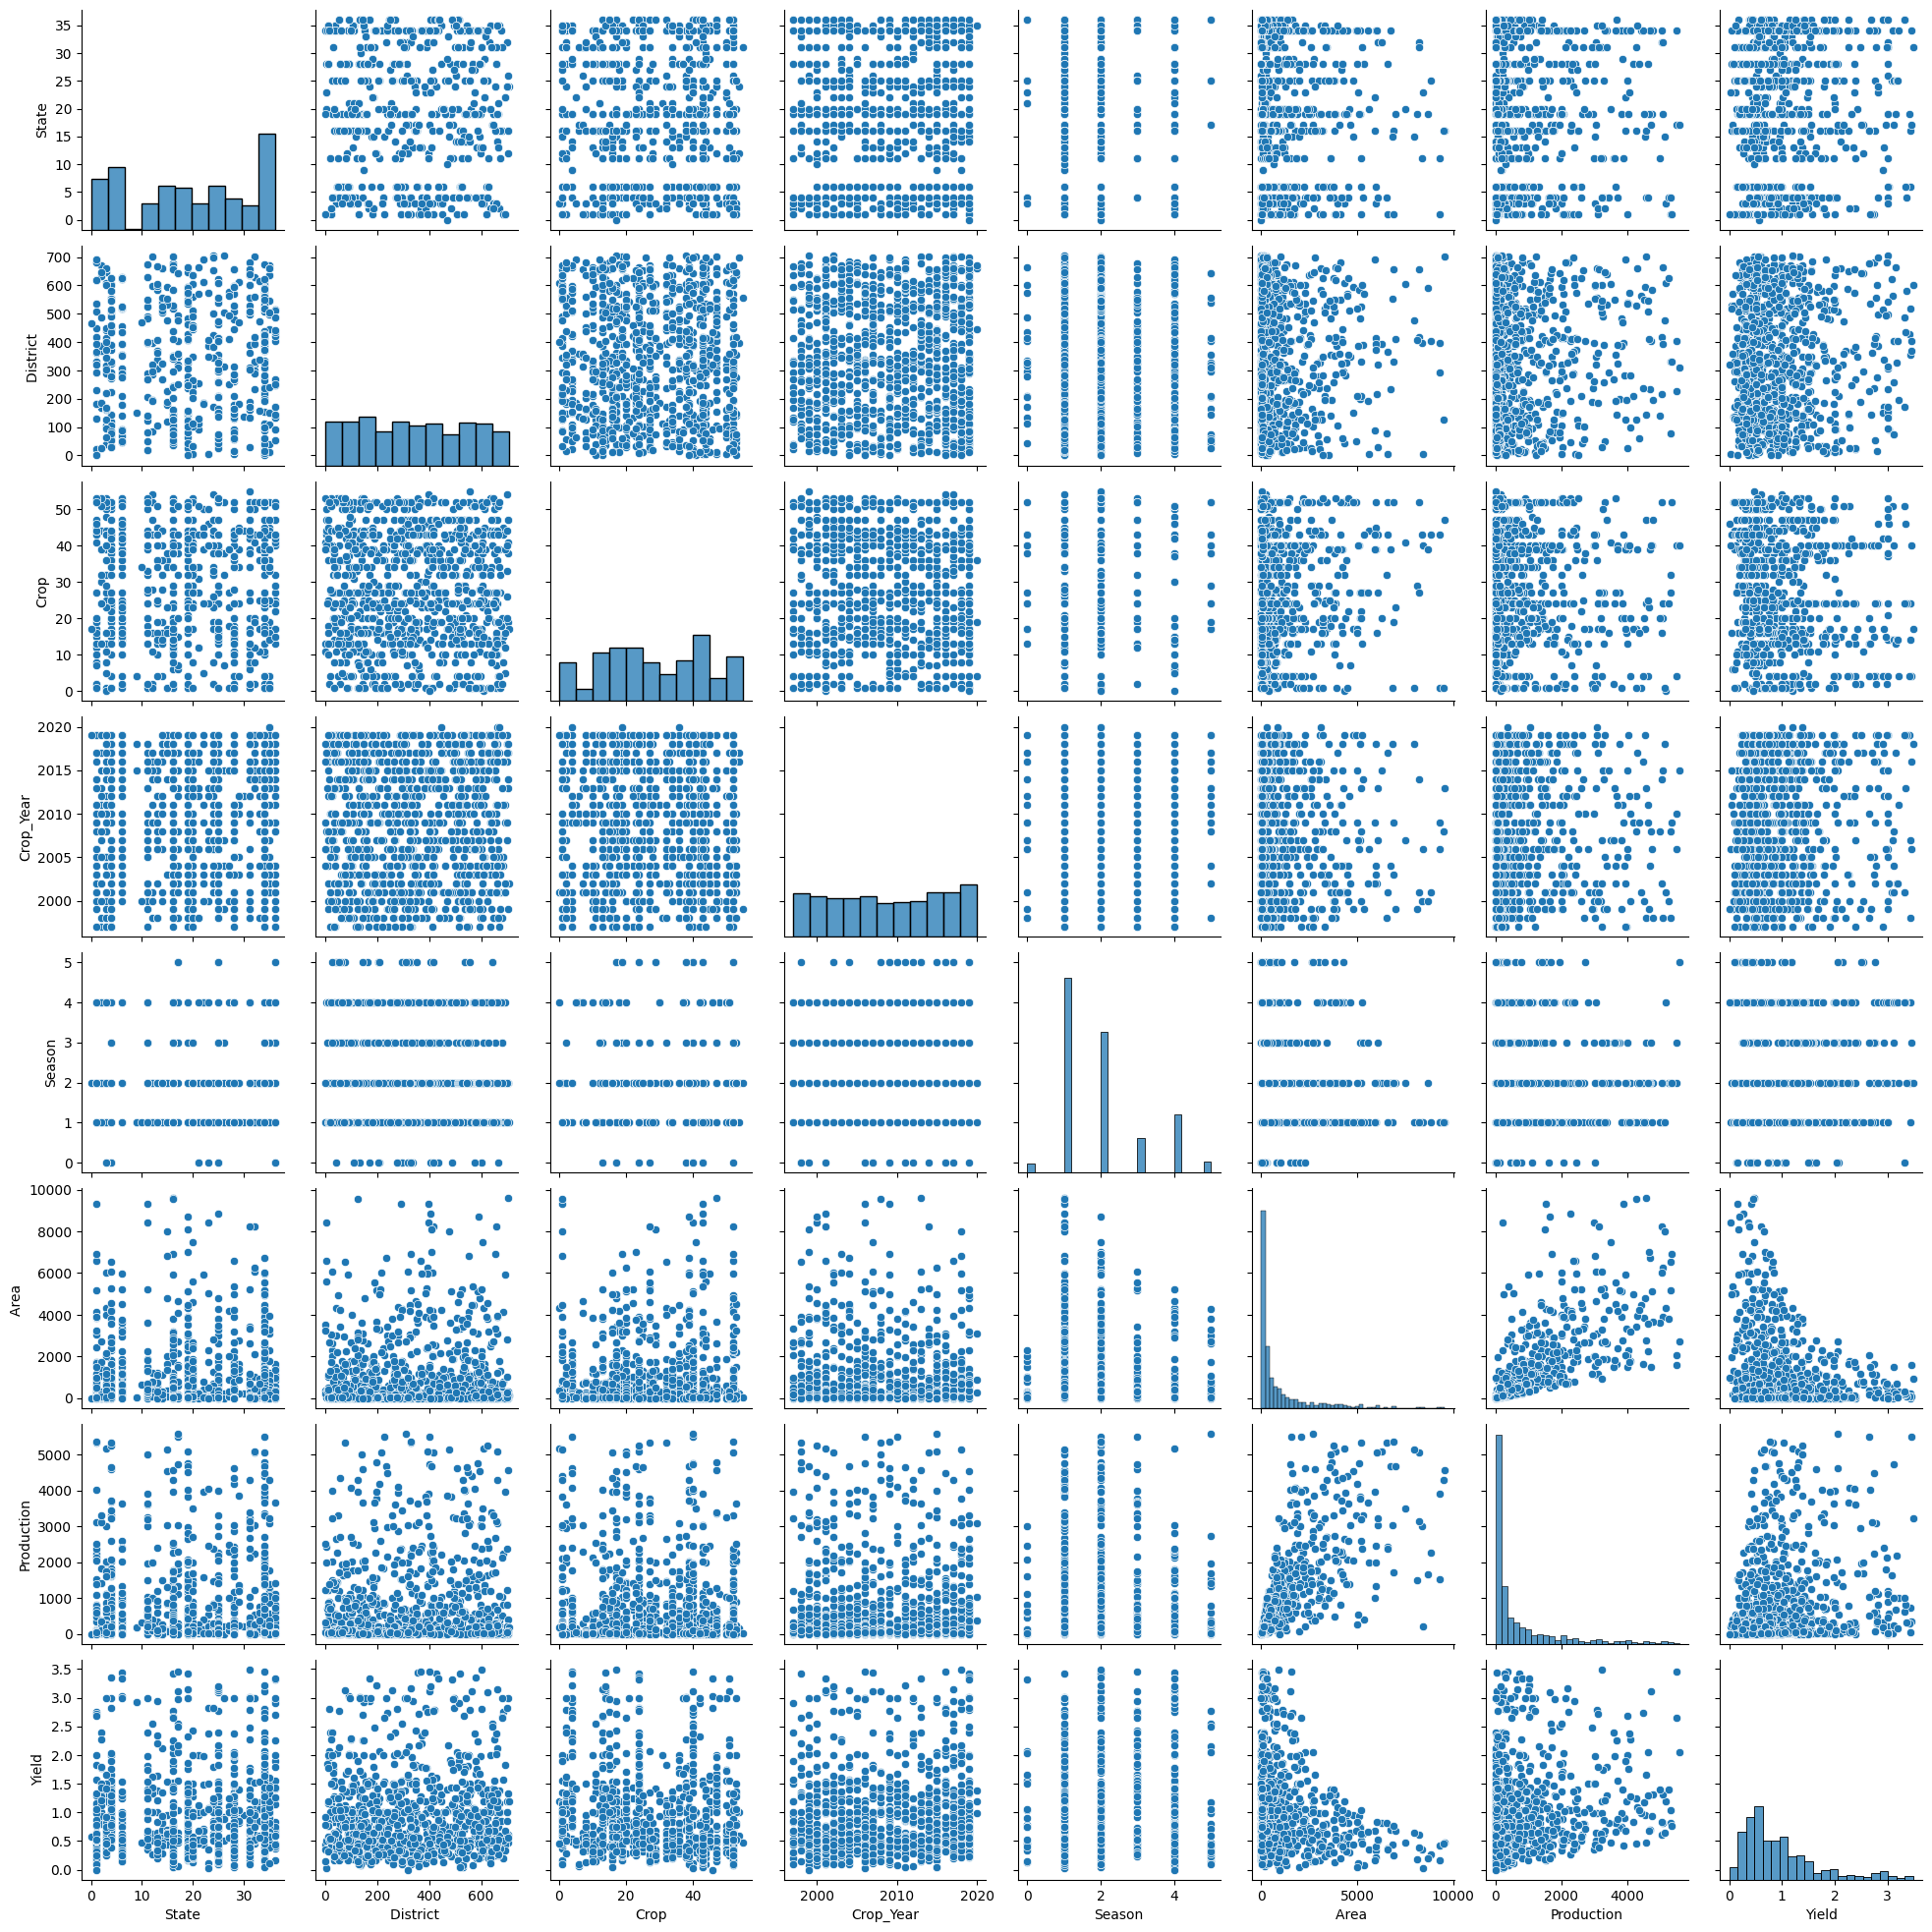

In [ ]:
# 4. Pairplot of Numerical Features
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(data[numerical_cols].sample(1000))
plt.show()
plt.close()



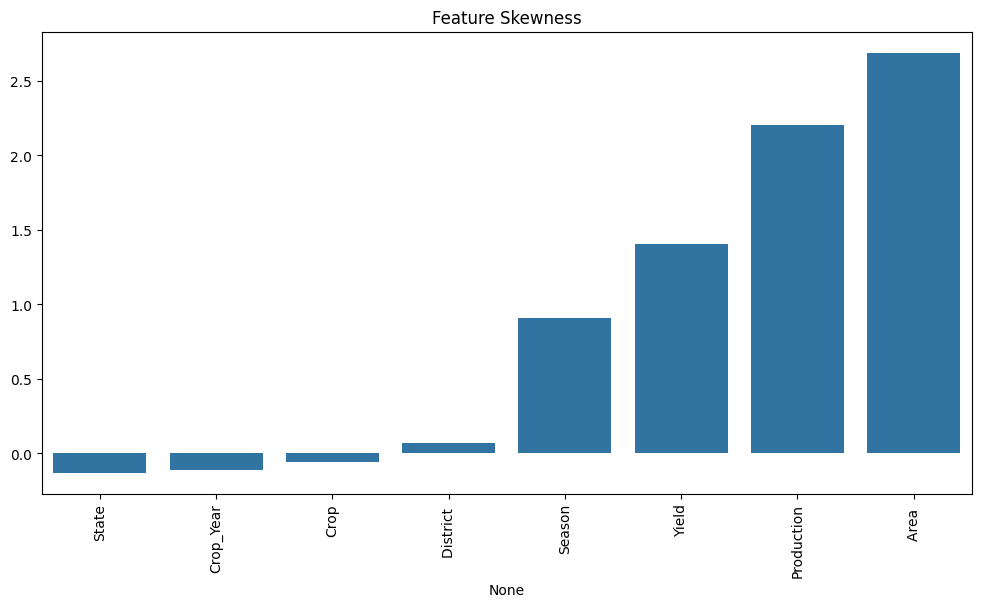

In [ ]:
# 5. Skewness Visualization
plt.figure(figsize=(12, 6))
skewness = data.skew().sort_values()
sns.barplot(x=skewness.index, y=skewness.values)
plt.xticks(rotation=90)
plt.title('Feature Skewness')
plt.show()
plt.close()



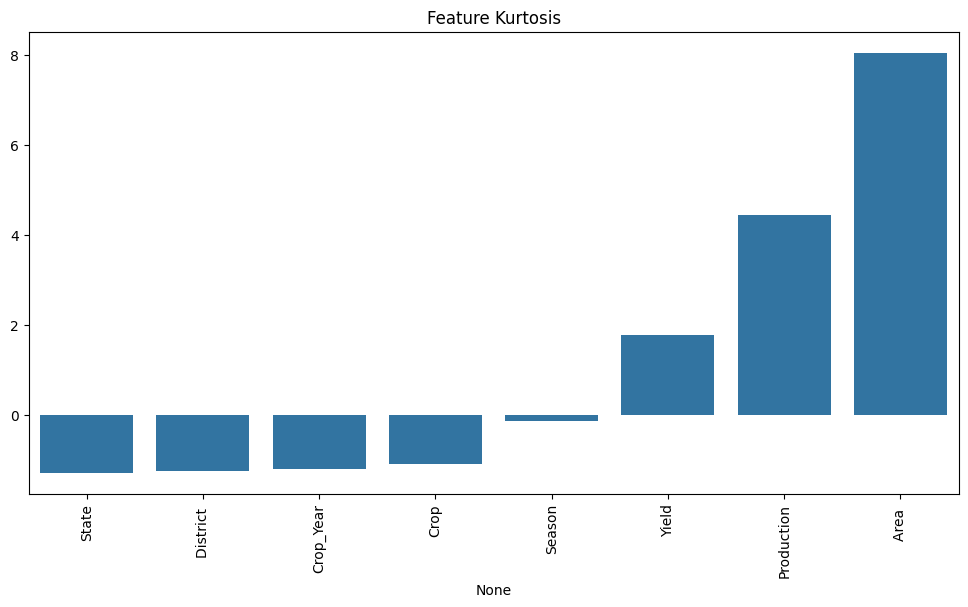

In [ ]:
# 6. Kurtosis Visualization
plt.figure(figsize=(12, 6))
kurtosis = data.kurtosis().sort_values()
sns.barplot(x=kurtosis.index, y=kurtosis.values)
plt.xticks(rotation=90)
plt.title('Feature Kurtosis')
plt.show()
plt.close()


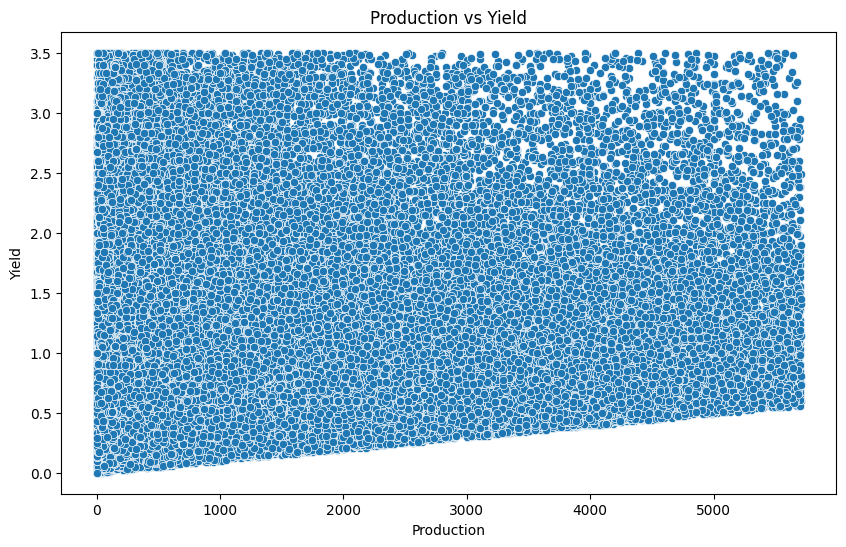

In [ ]:
# 7. Production vs Yield Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Production', y='Yield', data=data)
plt.title('Production vs Yield')
plt.show()
plt.close()


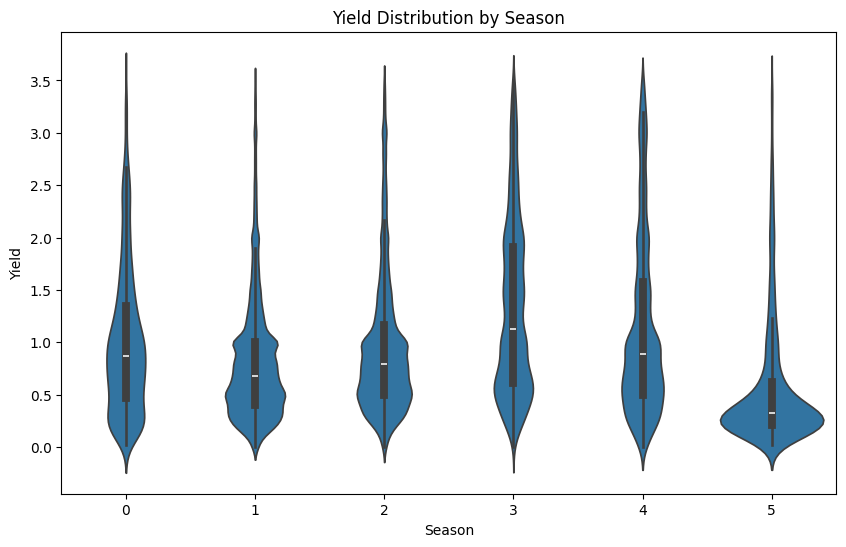

In [ ]:
# 8. Violin Plot of Yield by Season
plt.figure(figsize=(10, 6))
sns.violinplot(x='Season', y='Yield', data=data)
plt.title('Yield Distribution by Season')
plt.show()
plt.close()


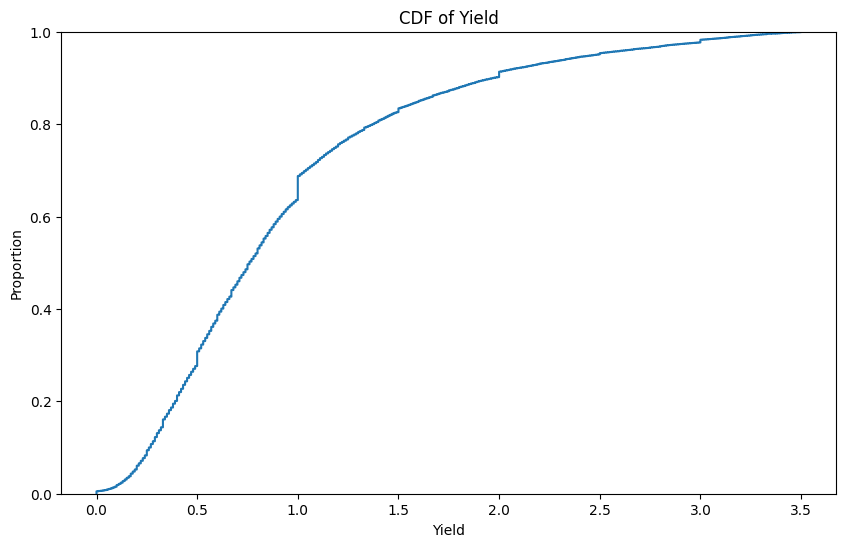

In [ ]:
# 9. Cumulative Distribution Function
plt.figure(figsize=(10, 6))
sns.ecdfplot(data['Yield'])
plt.title('CDF of Yield')
plt.show()
plt.close()

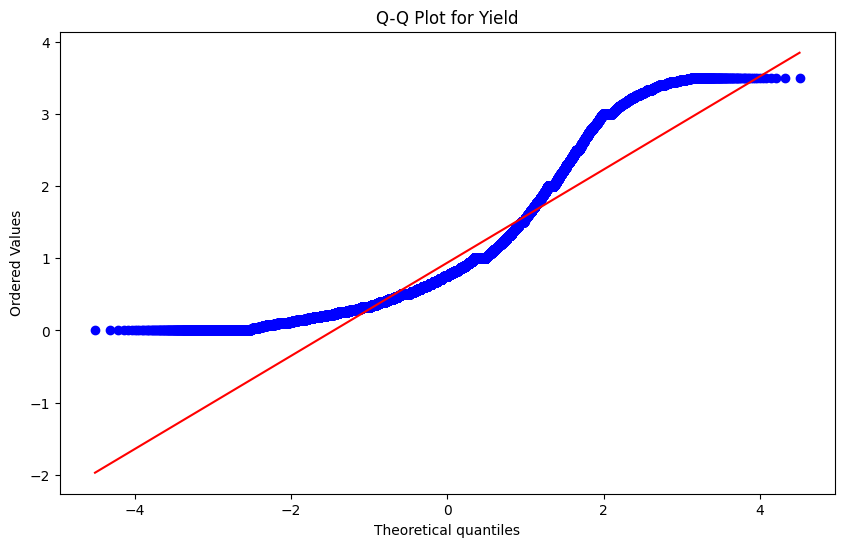

In [ ]:
# 10. QQ Plot for Normality Check
plt.figure(figsize=(10, 6))
stats.probplot(data['Yield'], plot=plt)
plt.title('Q-Q Plot for Yield')
plt.show()
plt.close()

In [ ]:
# 11. Time Series Plot (if temporal data exists)
if 'Year' in data.columns:
    plt.figure(figsize=(12, 6))
    yearly_yield = data.groupby('Year')['Yield'].mean()
    yearly_yield.plot()
    plt.title('Average Yield Over Years')
    plt.show()
    plt.close()

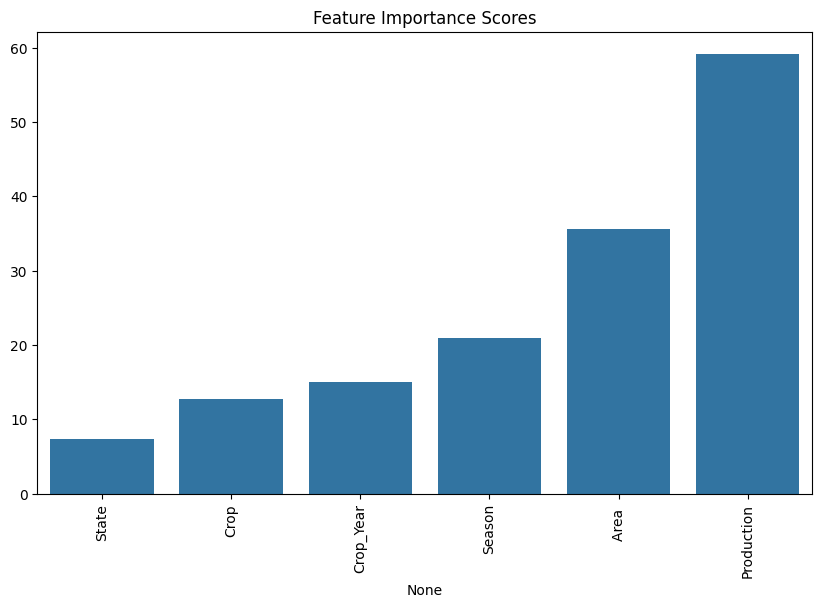

In [ ]:
# 12. Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=x.columns, y=score)
plt.xticks(rotation=90)
plt.title('Feature Importance Scores')
plt.show()
plt.close()

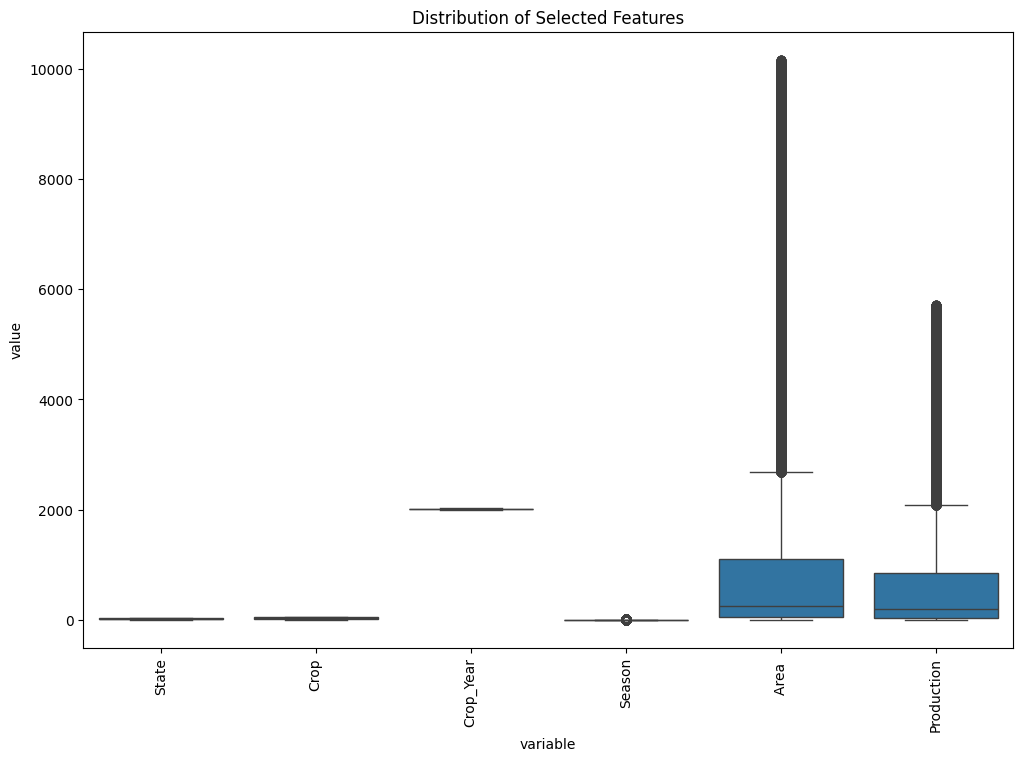

In [ ]:
# 13. Boxplot of Selected Features
plt.figure(figsize=(12, 8))
data_melted = data.melt(id_vars=['Yield'], value_vars=x.columns)
sns.boxplot(x='variable', y='value', data=data_melted)
plt.xticks(rotation=90)
plt.title('Distribution of Selected Features')
plt.show()
plt.close()


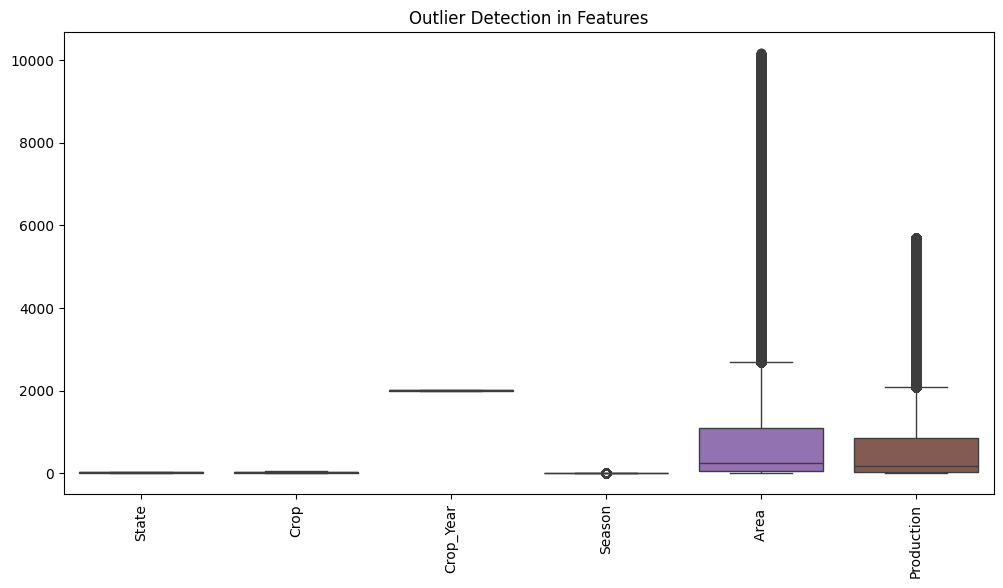

In [ ]:
# 14. Outlier Visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[x.columns])
plt.xticks(rotation=90)
plt.title('Outlier Detection in Features')
plt.show()
plt.close()

Epoch 1/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 2544.4285 - mse: 2544.4285 - val_loss: 0.3623 - val_mse: 0.3623
Epoch 2/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.4414 - mse: 0.4414 - val_loss: 0.4753 - val_mse: 0.4753
Epoch 3/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4867 - mse: 0.4867 - val_loss: 0.4754 - val_mse: 0.4754
Epoch 4/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.4841 - mse: 0.4841 - val_loss: 0.4751 - val_mse: 0.4751
Epoch 5/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.4778 - mse: 0.4778 - val_loss: 0.4751 - val_mse: 0.4751
Epoch 6/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4807 - mse: 0.4807 - val_loss: 0.4751 - val_mse: 0.4751
Epoch 7/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 0.4760 - mse: 0.4760 - val_loss: 0.4751 - val_mse: 0.4751
Epoch 8/32
5307/5307 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4773 - mse: 0.4773 - val_loss: 0.4750 - val_mse: 0.4750
Epoch 9/32
5307/5307 ━━━━━━

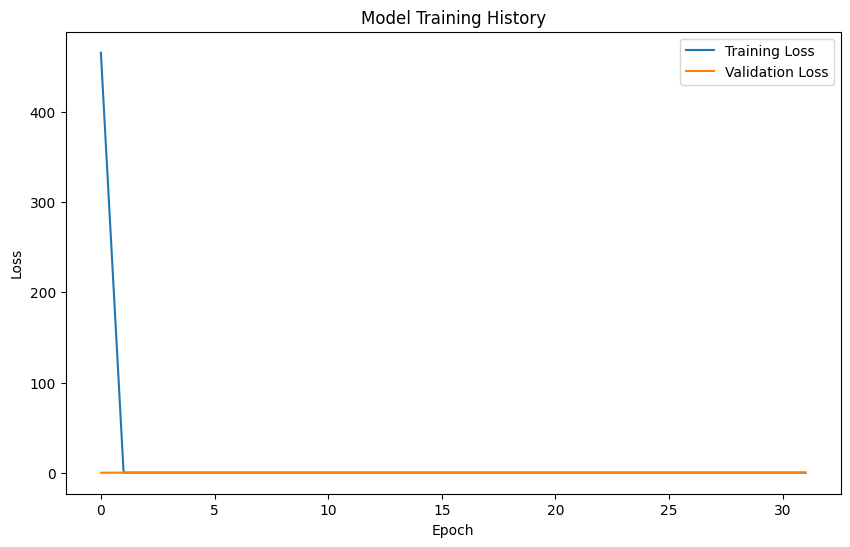

In [ ]:
# Neural Network Model
from tensorflow.keras.losses import MeanSquaredError

model = Sequential()
model.add(Dense(64, input_dim=x.shape[1], activation=tensorflow.keras.activations.relu))
model.add(Dense(32, activation=tensorflow.keras.activations.relu))
model.add(Dense(16, activation=tensorflow.keras.activations.linear))
model.add(Dropout(0.3))
model.add(Dense(1, activation=tensorflow.keras.activations.linear))
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])
history = model.fit(x_train, y_train, batch_size=30, epochs=32, validation_data=(x_test, y_test))
model.save('the_agr.h5')

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

In [ ]:
# Machine Learning Models
models = {
    "Extra_Trees": ExtraTreesRegressor(),
    "Hist_Gradient_Boosting": HistGradientBoostingRegressor(),
    "Random_Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MedianAE": median_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "ExplainedVariance": explained_variance_score(y_true, y_pred)
    }

results = {}
best_model_name = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    metrics = regression_metrics(y_test, y_pred)
    results[name] = metrics
    print(f"\n----- {name} -----")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Create actual vs predicted plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Actual vs Predicted')
    plt.savefig(f'./visualizations/{name}_actual_vs_predicted.png')
    plt.close()

    # Residual plot
    fig = plt.figure(figsize=(8, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residual Plot')
    plt.savefig(f'./visualizations/{name}_residual_plot.png')
    plt.close()

    if metrics['R2'] > best_r2:
        best_r2 = metrics['R2']
        best_model_name = name
        best_model = model
        joblib.dump(best_model, "best_model.pkl")
        print(f"\n✅ Best model '{best_model_name}' saved as 'best_model.pkl'")

# Model Comparison
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv('./visualizations/model_comparison.csv')

plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', y=['R2', 'MAE', 'RMSE'], subplots=True, layout=(1, 3), figsize=(18, 6))
plt.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.savefig('./visualizations/model_comparison.png')
plt.close()

print("\n=== Model Performance Summary ===")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

print(f"\n🏆 Best Model: {best_model_name} with R2: {best_r2:.4f}")


----- Extra_Trees -----
R2: 0.9958
MAE: 0.0170
MSE: 0.0020
RMSE: 0.0444
MedianAE: 0.0054
MAPE: 361715448155.4524
ExplainedVariance: 0.9958

✅ Best model 'Extra_Trees' saved as 'best_model.pkl'

----- Hist_Gradient_Boosting -----
R2: 0.9955
MAE: 0.0301
MSE: 0.0021
RMSE: 0.0464
MedianAE: 0.0198
MAPE: 982609987131.8501
ExplainedVariance: 0.9955

----- Random_Forest -----
R2: 0.9894
MAE: 0.0281
MSE: 0.0050
RMSE: 0.0709
MedianAE: 0.0078
MAPE: 431813499115.0357
ExplainedVariance: 0.9894

----- XGBoost -----
R2: 0.9960
MAE: 0.0294
MSE: 0.0019
RMSE: 0.0435
MedianAE: 0.0203
MAPE: 517099697671.9374
ExplainedVariance: 0.9960

✅ Best model 'XGBoost' saved as 'best_model.pkl'
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Machine Learning Models
models = {
    "Extra_Trees": ExtraTreesRegressor(),
    "Hist_Gradient_Boosting": HistGradientBoostingRegressor(),
    "Random_Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

def regression_metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MedianAE": median_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "ExplainedVariance": explained_variance_score(y_true, y_pred)
    }

results = {}
best_model_name = None
best_r2 = -np.inf

for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    metrics = regression_metrics(y_test, y_pred)
    results[name] = metrics
    print(f"\n----- {name} -----")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Create actual vs predicted plot
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{name} - Actual vs Predicted')
    plt.savefig(f'./visualizations/{name}_actual_vs_predicted.png')
    plt.close()

    # Residual plot
    fig = plt.figure(figsize=(8, 6))
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{name} - Residual Plot')
    plt.savefig(f'./visualizations/{name}_residual_plot.png')
    plt.close()

    if metrics['R2'] > best_r2:
        best_r2 = metrics['R2']
        best_model_name = name
        best_model = model
        joblib.dump(best_model, "best_model.pkl")
        print(f"\n✅ Best model '{best_model_name}' saved as 'best_model.pkl'")


----- Extra_Trees -----
R2: 0.9967
MAE: 0.0148
MSE: 0.0015
RMSE: 0.0393
MedianAE: 0.0049
MAPE: 329788146685.2651
ExplainedVariance: 0.9967

✅ Best model 'Extra_Trees' saved as 'best_model.pkl'

----- Hist_Gradient_Boosting -----
R2: 0.9956
MAE: 0.0303
MSE: 0.0021
RMSE: 0.0459
MedianAE: 0.0206
MAPE: 1049409272138.1406
ExplainedVariance: 0.9956

----- Random_Forest -----
R2: 0.9853
MAE: 0.0337
MSE: 0.0070
RMSE: 0.0837
MedianAE: 0.0093
MAPE: 544518061455.3004
ExplainedVariance: 0.9853

----- XGBoost -----
R2: 0.9960
MAE: 0.0294
MSE: 0.0019
RMSE: 0.0435
MedianAE: 0.0203
MAPE: 517099697671.9374
ExplainedVariance: 0.9960
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 159197, number of used features: 6
[LightGB

In [ ]:
# Model Comparison
metrics_df = pd.DataFrame(results).T
metrics_df.to_csv('./visualizations/model_comparison.csv')

plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', y=['R2', 'MAE', 'RMSE'], subplots=True, layout=(1, 3), figsize=(18, 6))
plt.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.savefig('./visualizations/model_comparison.png')
plt.close()

print("\n=== Model Performance Summary ===")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

print(f"\n🏆 Best Model: {best_model_name} with R2: {best_r2:.4f}")


=== Model Performance Summary ===

Extra_Trees:
  R2: 0.9967
  MAE: 0.0148
  MSE: 0.0015
  RMSE: 0.0393
  MedianAE: 0.0049
  MAPE: 329788146685.2651
  ExplainedVariance: 0.9967

Hist_Gradient_Boosting:
  R2: 0.9956
  MAE: 0.0303
  MSE: 0.0021
  RMSE: 0.0459
  MedianAE: 0.0206
  MAPE: 1049409272138.1406
  ExplainedVariance: 0.9956

Random_Forest:
  R2: 0.9853
  MAE: 0.0337
  MSE: 0.0070
  RMSE: 0.0837
  MedianAE: 0.0093
  MAPE: 544518061455.3004
  ExplainedVariance: 0.9853

XGBoost:
  R2: 0.9960
  MAE: 0.0294
  MSE: 0.0019
  RMSE: 0.0435
  MedianAE: 0.0203
  MAPE: 517099697671.9374
  ExplainedVariance: 0.9960

LightGBM:
  R2: 0.9956
  MAE: 0.0298
  MSE: 0.0021
  RMSE: 0.0457
  MedianAE: 0.0200
  MAPE: 969051670322.3307
  ExplainedVariance: 0.9956

🏆 Best Model: Extra_Trees with R2: 0.9967


<Figure size 1200x600 with 0 Axes>